In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

In [10]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
from IPython.display import display

In [7]:
train = pd.read_csv('C:/Users/us61565/Desktop/Internal/Internal/Home Prices/train.csv')
test = pd.read_csv('C:/Users/us61565/Desktop/Internal/Internal/Home Prices/test.csv')

In [12]:
print("Length of the train set is {}".format(train.shape[0]))
print("Width of the train set is {}".format(train.shape[1]))
print("Length of the test set is {}".format(test.shape[0]))
print("Width of the test set is {}".format(test.shape[1]))

Length of the train set is 1460
Width of the train set is 81
Length of the test set is 1459
Width of the test set is 80


In [18]:
# column types
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [20]:
pandas_profiling.ProfileReport(train)

#### Checking NaNs manually: showing the number of missing observations in one column and % of missing values in another   

In [94]:
# First create a dictionary with columns and number of missing values
missing_dict = {}
for i in train.columns:
    missing_dict[i] = train[i].isna().sum()

In [ ]:
missing_dict

In [135]:
# List with missing percentages 
missing_percentage = []
for i in train.columns:
    missing_percentage.append(train[i].isna().sum()/len(train[i]))

In [112]:
# Creating a dataframe from missing_dict:
df_missing = pd.DataFrame.from_dict(missing_dict, orient='index')

In [114]:
df_missing.reset_index(inplace=True)

In [124]:
df_missing.rename(columns={"index":"Feature",0:"Missing_values"}, inplace=True)

In [127]:
df_missing.head()

Feature  Missing_values
0           Id               0
1   MSSubClass               0
2     MSZoning               0
3  LotFrontage             259
4      LotArea               0

In [136]:
# adding a % of missing values as a new column
df_missing['Missing_%'] = missing_percentage

In [137]:
df_missing.head()

Feature  Missing_values  Missing_%
0           Id               0      0.000
1   MSSubClass               0      0.000
2     MSZoning               0      0.000
3  LotFrontage             259      0.177
4      LotArea               0      0.000

In [143]:
df_missing.sort_values(by=['Missing_%'], ascending=False)

Feature  Missing_values  Missing_%
72       PoolQC            1453      0.995
74  MiscFeature            1406      0.963
6         Alley            1369      0.938
73        Fence            1179      0.808
57  FireplaceQu             690      0.473
..          ...             ...        ...
27    ExterQual               0      0.000
24  Exterior2nd               0      0.000
23  Exterior1st               0      0.000
22     RoofMatl               0      0.000
80    SalePrice               0      0.000

[81 rows x 3 columns]

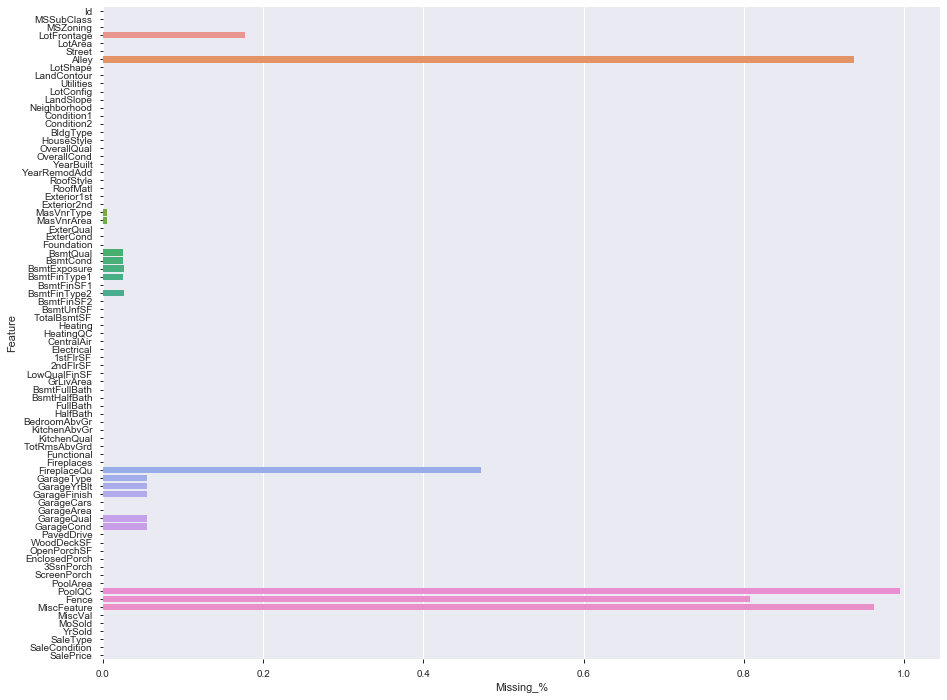

In [185]:
fig, ax = plt.subplots(figsize=(15,12))
sns.barplot(x=df_missing['Missing_%'], y=df_missing['Feature'], orient='h')

In [ ]:
# Before dropping columns with lot's of NaNs (like where >80%), let's see if they correlate with SalePrice somehow

In [160]:
candidates_to_drop = df_missing.loc[df_missing['Missing_%']>0.8]

In [161]:
candidates_to_drop

Feature  Missing_values  Missing_%
6         Alley            1369      0.938
72       PoolQC            1453      0.995
73        Fence            1179      0.808
74  MiscFeature            1406      0.963

In [163]:
# Let's drop them indeed
train['Alley'].value_counts()
train['MiscFeature'].value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

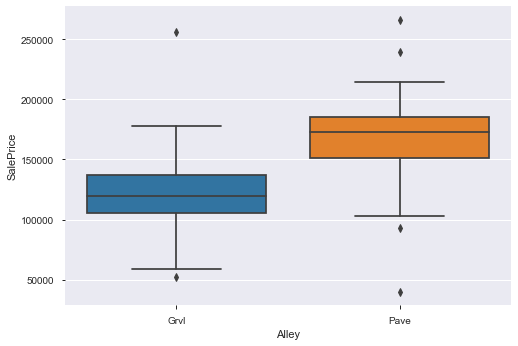

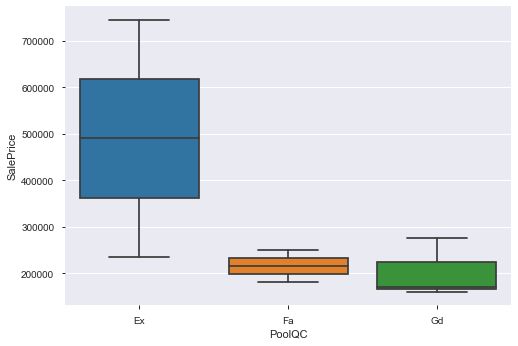

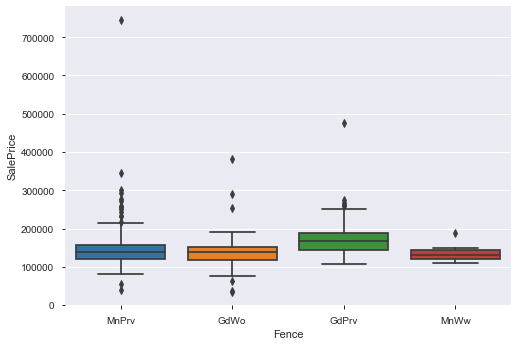

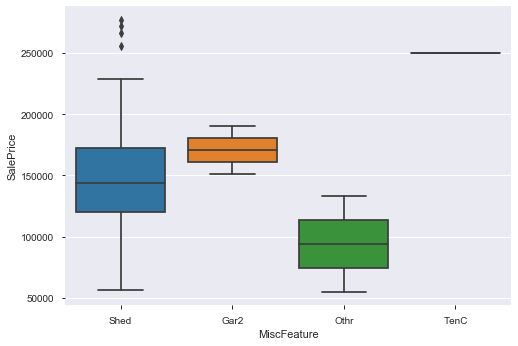

In [151]:
for k in candidates_to_drop['Feature']:
    plt.figure()
    sns.boxplot(x=train[k], y=train['SalePrice'])
    plt.plot()

In [164]:
candidates_to_drop['Feature'].to_list()

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [165]:
train1 = train.drop(labels=candidates_to_drop['Feature'].to_list(), axis = 1)

In [167]:
train1.shape[1]
# was 81, now 77

77

#### Looking at variables' distributions:

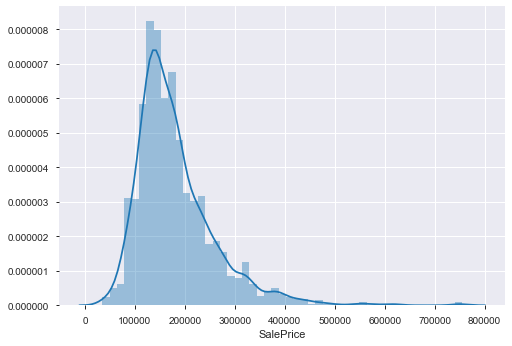

In [21]:
# Assess the dependent variable SalePrice
sns.distplot(train['SalePrice'])

In [22]:
print("Skewness of SalePrice is {}".format(train['SalePrice'].skew()))

Skewness of SalePrice is 1.8828757597682129


In [35]:
# not necessarily
train1['YearBuilt'] = pd.to_datetime(train['YearBuilt'])
train1['YrSold'] = pd.to_datetime(train['YrSold'])

In [ ]:
# Not necesarily 
train1['YrSold'].apply(lambda x: x.year)
train1['YearBuilt'].apply(lambda x: x.year)

In [168]:
# how the dep variable moves with numerical features:
num_feat = train1.select_dtypes(exclude = ["object"]).columns
num_feat = num_feat.drop(["SalePrice","Id"])

In [169]:
num_feat

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [170]:
for_chart = ['LotFrontage', 'LotArea', 'OverallQual','BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF']

In [50]:
for n in for_chart:
    print(n)

LotFrontage
LotArea
OverallQual
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF


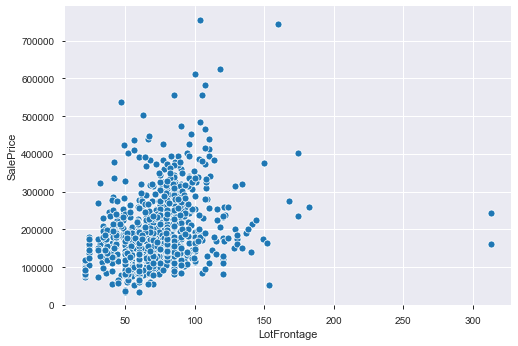

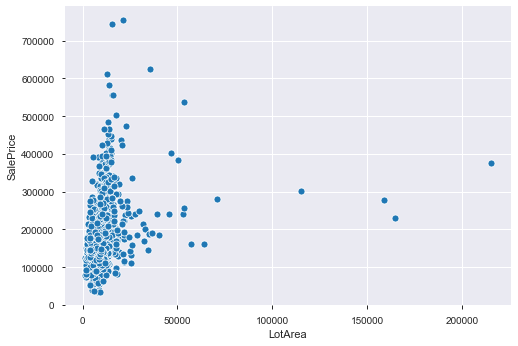

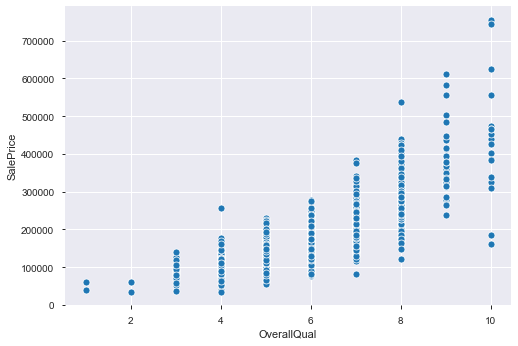

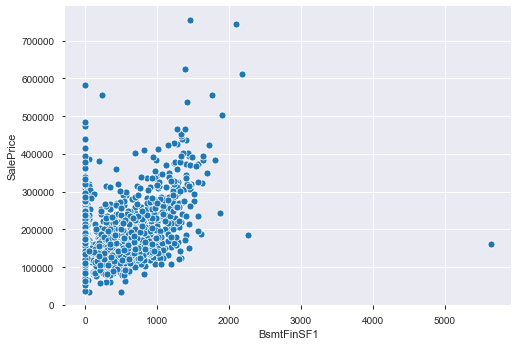

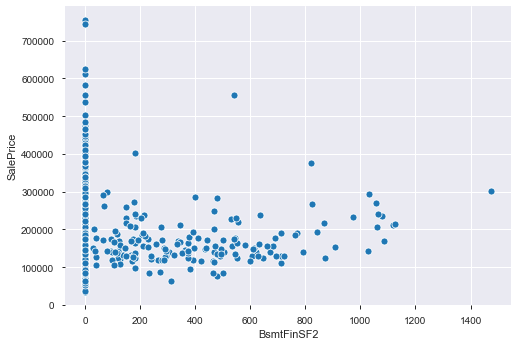

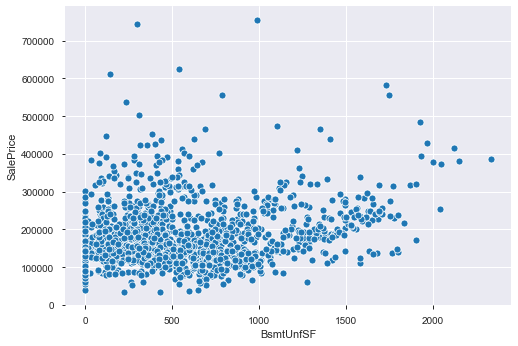

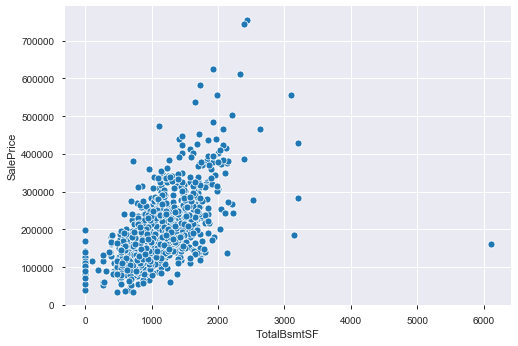

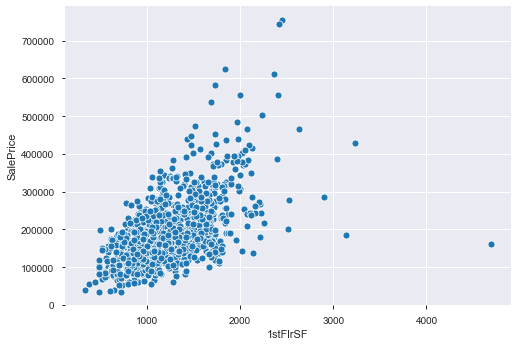

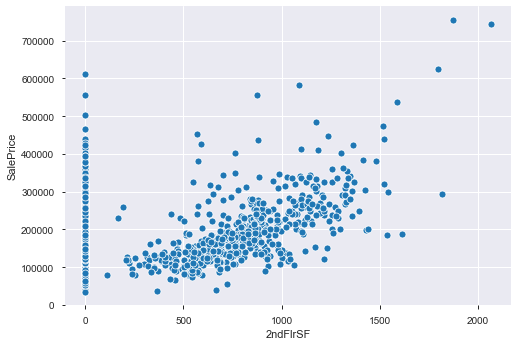

In [56]:
# fig, ax = plt.subplots(figsize=(15,10))
for n in for_chart:
    plt.figure(n)
    sns.scatterplot(x=train[n], y=train['SalePrice'])
    plt.plot()


In [171]:
train1.select_dtypes(include = ["object"]).columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [172]:
train1['SaleCondition'].unique()

array(['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'],
      dtype=object)

In [66]:
for_boxplot = ['LotShape','LandContour','Neighborhood', 'Condition1', 'Condition2','BldgType','SaleType','SaleCondition']

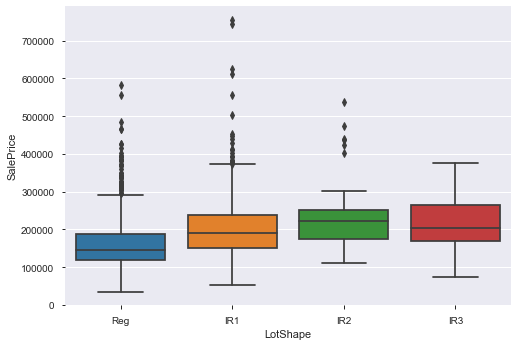

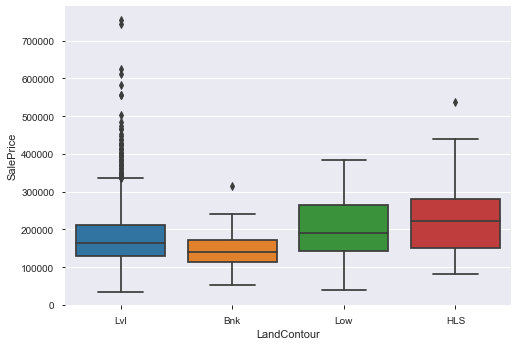

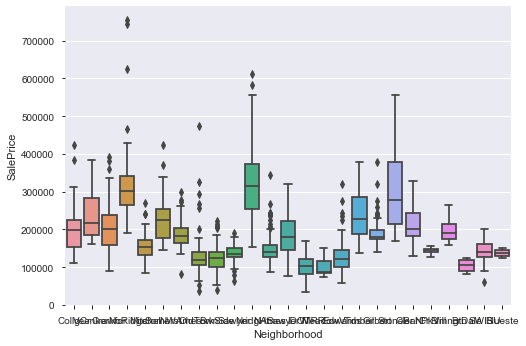

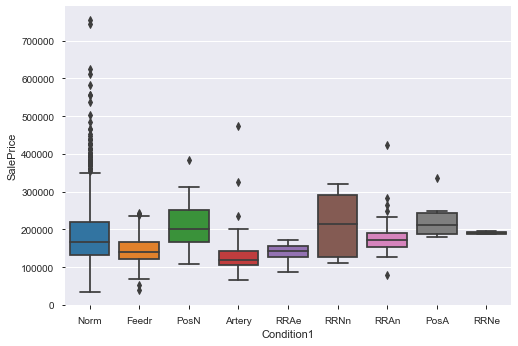

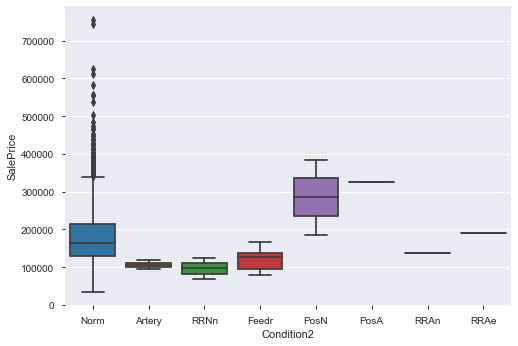

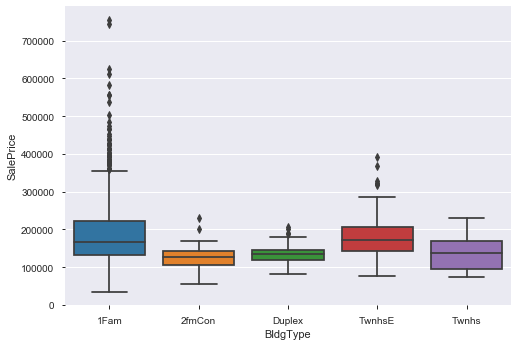

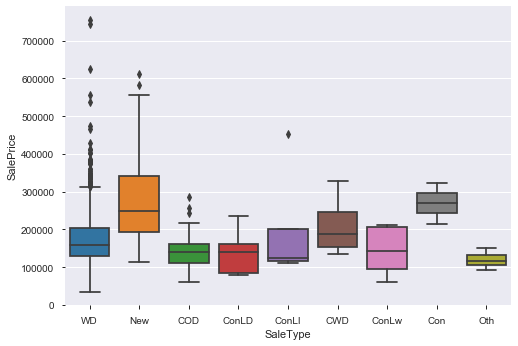

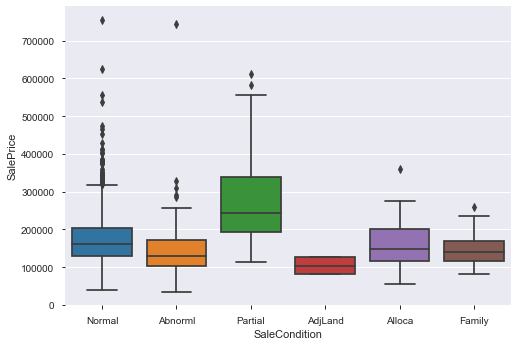

In [173]:
for m in for_boxplot:
    plt.figure(m)
    sns.boxplot(x=train1[m], y=train['SalePrice'])
    plt.plot()


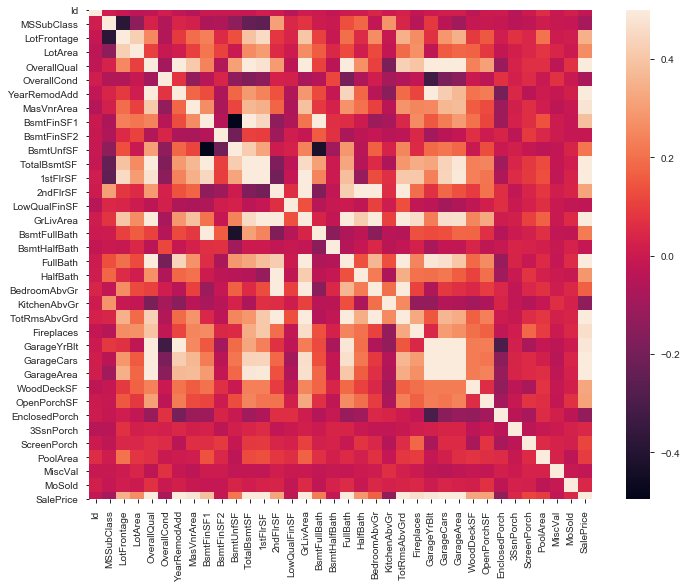

In [175]:
#### Correlations between all the variables
corrmat = train1.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.5, square=True);

In [192]:
# GarageQual and GarageCond look similar:
df_missing.loc[df_missing['Feature'].isin(['GarageQual','GarageCond'])]

Feature  Missing_values  Missing_%
63  GarageQual              81      0.055
64  GarageCond              81      0.055

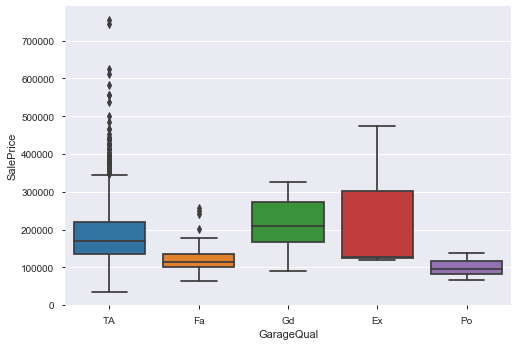

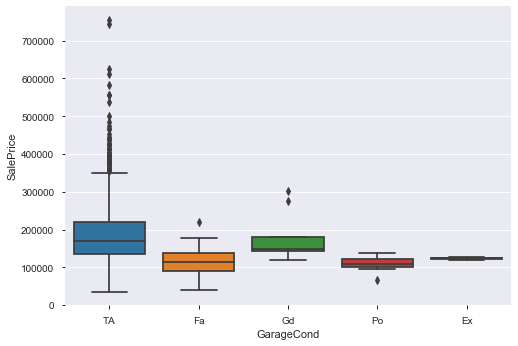

In [193]:
for k in ['GarageQual', 'GarageCond']:
    plt.figure(k)
    sns.boxplot(x=train1[k], y=train1['SalePrice'])
    plt.plot()

In [ ]:
# We will drop GarageCond later

#### Dealing with NaNs

In [277]:
# Be careful as I'm working again with train. Decided not to drop the four columns but encode NaNs explicitly

train# BedroomAbvGr : NA most likely means 0
train.loc[:, "BedroomAbvGr"] = train.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
train.loc[:, "CentralAir"] = train.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
train.loc[:, "Condition1"] = train.loc[:, "Condition1"].fillna("Norm")
train.loc[:, "Condition2"] = train.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
train.loc[:, "EnclosedPorch"] = train.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
train.loc[:, "ExterCond"] = train.loc[:, "ExterCond"].fillna("TA")
train.loc[:, "ExterQual"] = train.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")
train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
train.loc[:, "Functional"] = train.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
train.loc[:, "HalfBath"] = train.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
train.loc[:, "HeatingQC"] = train.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
train.loc[:, "KitchenAbvGr"] = train1.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
train.loc[:, "KitchenQual"] = train.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
train.loc[:, "LotShape"] = train.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)
train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
train.loc[:, "OpenPorchSF"] = train.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
train.loc[:, "PavedDrive"] = train.loc[:, "PavedDrive"].fillna("N")
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
train.loc[:, "SaleCondition"] = train.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
train.loc[:, "ScreenPorch"] = train.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
train.loc[:, "TotRmsAbvGrd"] = train.loc[:, "TotRmsAbvGrd"].fillna(0)
train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("NA")
# Utilities : NA most likely means all public utilities
train.loc[:, "Utilities"] = train.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
train.loc[:, "WoodDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)

In [196]:
train.isna().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 81, dtype: int64

In [197]:
# Some numerical features are actually really categories
train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [ ]:
train = train.replace({"BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       #"PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

#### Feature engineering

In [200]:
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
train["FullBath"] + (0.5 * train["HalfBath"])
# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
train["3SsnPorch"] + train["ScreenPorch"]
# Has masonry veneer or not
train["HasMasVnr"] = train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [ ]:
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

In [202]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 59
Categorical features : 27


In [204]:
train_num.columns

Index(['Id', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'Utilities',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'PoolQC', 'MiscVal', 'YrSold', 'TotalBath', 'AllSF', 'AllFlrsSF',
       'AllPorchSF', 'HasMasVnr', 'BoughtOffPlan'],
      dtype='object')

In [ ]:
# We will drop columns that were used for creating combined features DON"T DO IT
from_comb_feat = ["BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","GrLivArea","TotalBsmtSF","1stFlrSF", "2ndFlrSF",
                 "OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch", "MasVnrType" ]
train2 = train.drop(columns=from_comb_feat, axis = 1)

In [209]:
len(train2.columns)

74

In [216]:
# Log transformation for skewed numerical features: 
skewness = train_num.drop(columns=['YearBuilt','YrSold'], axis=1).apply(lambda x: scipy.stats.skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

43 skewed numerical features to log transform


In [ ]:
# Let's check how transformed features look like:

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([  1300,   1477,   1491, ..., 159000, 164660, 215245], dtype=int64)),
 (5888.761357966362, 10516.828082191783, 0.589007650490991))

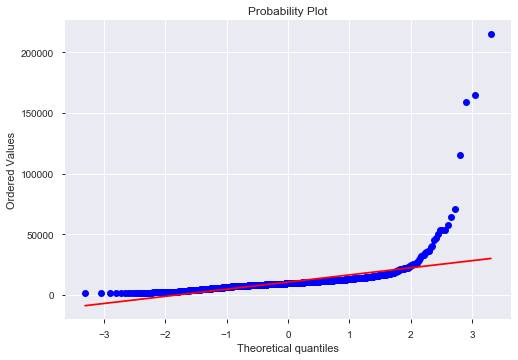

In [224]:
scipy.stats.probplot(train['LotArea'], plot=plt)

#### Dummies

In [281]:
train_cat = pd.get_dummies(train_cat)

In [282]:
# Combining train_cat and train_num
train3 = pd.concat([train_num, train_cat], axis = 1)

In [283]:
train3.shape

(1460, 265)

In [235]:
len(train['SalePrice'])

1460

In [284]:
# Putting SalePrice into y
y = train['SalePrice'].values

In [285]:
# train3['YrSold'].dtypes
#Need to convert YrSold to int, otherwise fit_transform won't work
train3['YrSold'] = pd.to_numeric(train3['YrSold'])
train3['YearBuilt'] = pd.to_numeric(train3['YearBuilt'])

In [ ]:
# To track datetime columns that can't go into 
train3.select_dtypes(include=['datetime64'])

In [287]:
# Splitting into train and test:
X_train, X_test, y_train, y_test = train_test_split(train3, y, test_size = 0.2, random_state = 43)

In [288]:
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

## Modelling

#### Linear regression

In [289]:
reg = LinearRegression()

#### Mask to find columns/rows with NaNs

In [294]:
col_mask=X_train.isnull().any(axis=0) 
row_mask=X_train.isnull().any(axis=1)

In [303]:
X_train.loc[row_mask,col_mask]

Empty DataFrame
Columns: []
Index: [638, 1449, 441, 148, 968, 393, 1011, 705, 1325, 464, 1450, 125, 431, 533, 163, 976, 250, 88, 1219, 39, 649, 241, 535, 960, 826, 386, 954, 1030, 528, 210, 1349, 1326, 1218, 291, 155, 1137, 165, 1453, 434, 287, 750, 613, 1131, 1096, 89, 1009, 1143, 562, 1337, 582, 78, 1234, 738, 1407, 1257, 1173, 784, 1038, 1179, 635, 198, 1123, 921, 1283, 843, 307]

[66 rows x 0 columns]

In [296]:
# X_train.drop(['PoolQC','GarageYrBlt'], axis=1, inplace=True)
# X_test.drop(['PoolQC','GarageYrBlt'], axis=1, inplace=True)

In [297]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [300]:
y_pred_reg = reg.predict(X_test)

In [301]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred_reg))

Mean squared error: 111018504852743253825958182912.00


In [302]:
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred_reg))

Coefficient of determination: -17439180319280312320.00


#### With L2 regularization

In [307]:
# First, let's look for good alphas
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 10.0


In [308]:
# closer around 10
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 14.0


C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [309]:
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

In [373]:
r2_score(y_test, y_test_rdg)

0.8547174938497903

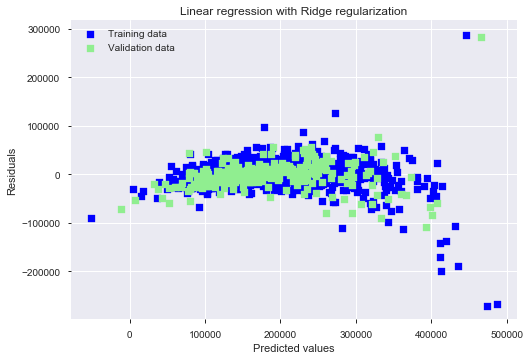

In [310]:
# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

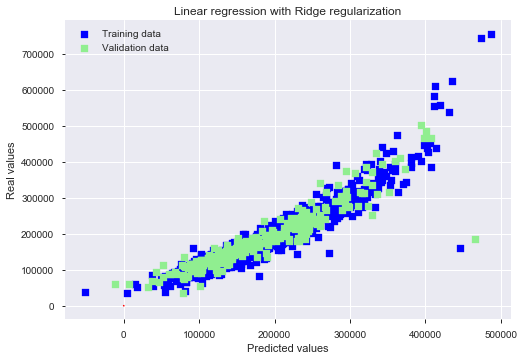

In [311]:
# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Ridge picked 260 features and eliminated the other 3 features


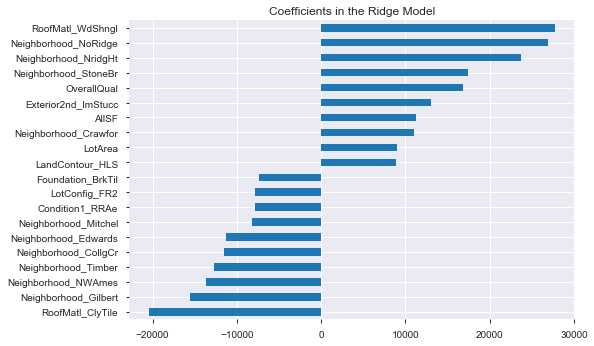

In [312]:
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

#### Lasso (L1 regularization)

In [314]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Best alpha : 1.0
Try again for more precision with alphas centered around 1.0
Best alpha : 1.4


In [315]:
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

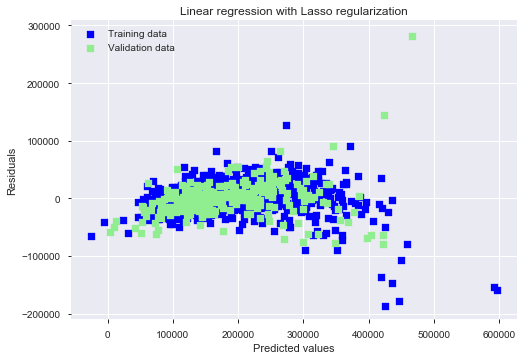

In [316]:
# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

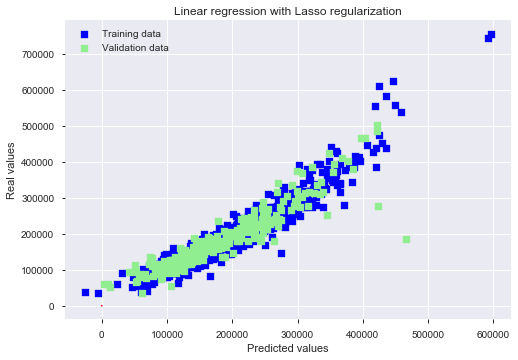

In [317]:
# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Lasso picked 240 features and eliminated the other 23 features


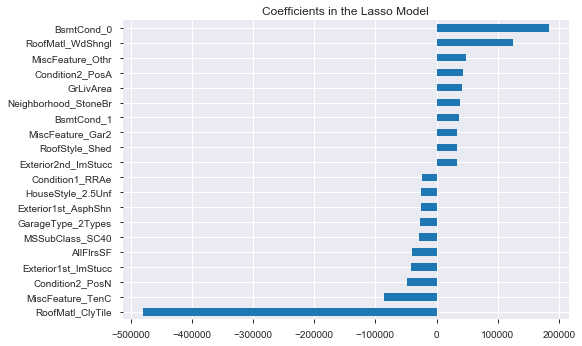

In [318]:
# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

#### ElasticNet

In [320]:
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Best l1_ratio : 0.7
Best alpha : 0.06


In [321]:
print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Try again for more precision with l1_ratio centered around 0.7
Best l1_ratio : 0.8049999999999999
Best alpha : 0.1
Now try again for more precision on alpha, with l1_ratio fixed at 0.8049999999999999 and alpha centered around 0.1
Best l1_ratio : 0.8049999999999999
Best alpha : 0.095


In [323]:
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

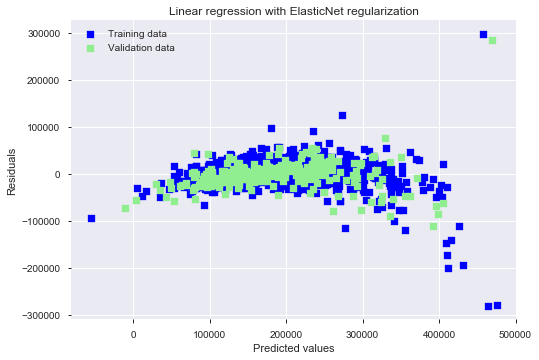

In [324]:
# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

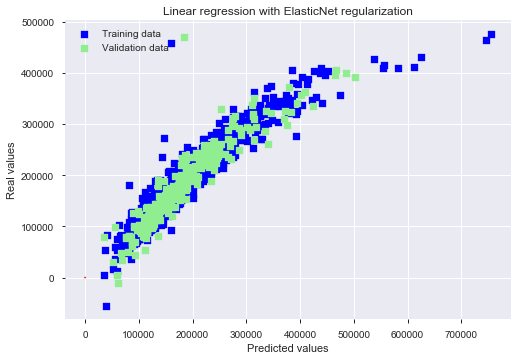

In [325]:
# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

ElasticNet picked 260 features and eliminated the other 3 features


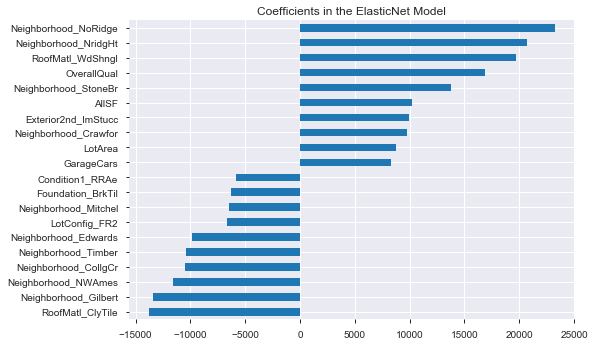

In [326]:
# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

In [327]:
import pickle

In [331]:
# infile = open("C:/Users/us61565/Desktop/Internal/Internal/Gartner/counter_dataset",'rb')
gartner = pd.read_pickle("C:/Users/us61565/Desktop/Internal/Internal/Gartner/counter_dataset")
# infile.close()

In [334]:
gartner.head()

asin review_post_id  \
0  B000I68EL8  RZZQSQMVMPTW3   
1  B000I68EL8  RZZI5BHNRQS5Z   
2  B000I68EL8  RZN7OFKFGQO0N   
3  B000I68EL8  RZLEB1YTRQQ33   
4  B000I68EL8  RZI71N4TZRCMD   

                                                body  \
0  it feels so comfortable and I can wear it all ...   
1  Package came with the end missing from the box...   
2  Birkenstock is an amazing shoe!!!!  I wish I h...   
3  Delivered as advertised.... shoe looks & fits ...   
4        Second pair I have had. Nothing beats them.   

                                         review_text  helpful_count  \
0                      feels comfortable i wear day!              0   
1  package came end missing box. since it’s gift ...              0   
2   birkenstock amazing shoe!!!! i wish i ten pairs!              0   
3  delivered advertised.... shoe looks & fits exp...              0   
4             second pair i had. nothing beats them.              0   

   num_images  rating date_posted  is_verified_purchase  is_vine_voice  ...  \
0           0       5  2017-07-27                  True          False  ...   
1           1       3  2017-12-24                  True          False  ...   
2           0       5  2017-05-31                  True          False  ...   
3           0       5  2018-06-24                  True          False  ...   
4           0       5  2017-02-05                  True          False  ...   

   is_prime_pantry  is_prime_exclusive is_fresh  has_sns  offer_fulfiller  \
0            False               False    False    False     Houser Shoes   
1            False               False    False    False     Houser Shoes   
2            False               False    False    False     Houser Shoes   
3            False               False    False    False     Houser Shoes   
4            False               False    False    False     Houser Shoes   

   offer_merchant lowest_price_new_condition        brand num_reviews  \
0    Houser Shoes                        nan  Birkenstock      22.000   
1    Houser Shoes                        nan  Birkenstock      22.000   
2    Houser Shoes                        nan  Birkenstock      22.000   
3    Houser Shoes                        nan  Birkenstock      22.000   
4    Houser Shoes                        nan  Birkenstock      22.000   

  num_images_pdp  
0          8.000  
1          8.000  
2          8.000  
3          8.000  
4          8.000  

[5 rows x 28 columns]

In [346]:
gartner.to_csv("counter_gartner.csv", index=False)

In [347]:
pwd

'C:\\Users\\us61565\\Desktop\\Internal\\Internal\\Brex\\data_challenge'

In [335]:
gartner.columns.to_list()

['asin',
 'review_post_id',
 'body',
 'review_text',
 'helpful_count',
 'num_images',
 'rating',
 'date_posted',
 'is_verified_purchase',
 'is_vine_voice',
 'num_comments',
 'has_video',
 'category',
 'list_price',
 'price_low',
 'price_high',
 'is_add_on',
 'is_prime',
 'is_prime_pantry',
 'is_prime_exclusive',
 'is_fresh',
 'has_sns',
 'offer_fulfiller',
 'offer_merchant',
 'lowest_price_new_condition',
 'brand',
 'num_reviews',
 'num_images_pdp']

In [342]:
# pickle.dump(gartner, "C:/Users/us61565/Desktop/Internal/Internal/Gartner/counter_dataset/gartner.csv")
file = open("C:/Users/us61565/Desktop/Internal/Internal/Gartner/counter_dataset/counter_dataset2.pkl",'wb')
# pickle.dump("C:/Users/us61565/Desktop/Internal/Internal/Gartner/counter_dataset/gartner.csv", file)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/us61565/Desktop/Internal/Internal/Gartner/counter_dataset/counter_dataset2.pkl'

In [340]:
file.close()

In [359]:
assert sum([3,5]) == 8, "Should be 8"

In [360]:
import matplotlib.pyplot as plt

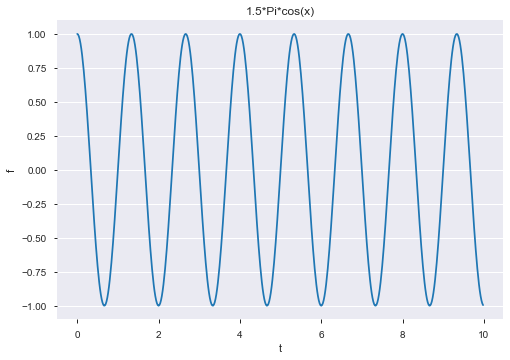

In [367]:
t = np.arange(0, 10, 0.02)
f = np.cos(3/2 * np.pi * t)

plt.plot(t, f)
plt.xlabel("t")
plt.ylabel("f")
plt.title("1.5*Pi*cos(x)")
plt.grid(False, axis='x')